# Importation des packages necessaires à l'étude 

In [268]:
# Import des packages
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import scipy.stats as st
import os
import sys
from skimpy import skim
import matplotlib.pyplot as plt


sys.path.insert(0, str(Path(os.getcwd()).resolve().parent.parent))
from Churn_contrat_auto.src.utils.tools import (
    rename_field_categories,
    distrib_for_cat_by_target,
    distrib_for_cont_by_target,
    boxplot_by_target,
    plot_generic,
    cramers_v_between_all,
    cramers_v_with_target,
    graph_correlations,
    extract_corr_pairs,
)



In [269]:
display.max_columns = None

#### Objectif : cibler les clients qui vont résilier leur contrat auto

# 1. Import des données

In [270]:
df = pd.read_csv("/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/raw/ResiliationContratAuto.txt", 
                 sep = '|',
                 encoding = 'latin1') # On rajoute l'encoding car ici nous ne sommes pas en utf8
df.head()

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_6769/20778580.py:1: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/raw/ResiliationContratAuto.txt",


,NO_AFR,CDUSGAUT,IDECON,CD_AGT,CD_FML,CDPRGES,DTDBUCON,DTEFTMVT,MMJECHPP,MTPAATTC,...,RESIV,RESDI,CLIACTIF,U,CONTRAT,ETAT,MOTIFRSL,COEFCOMM,COEFPFLT,CRM
0,A00104001204707,611.0,205808992,A00104,R,4190A,14630,14812,121.0,1929.66,...,NaN,NaN,OUI,0.630638,ACTIF,CO,NaN,100,0.8500,50
1,A00104001270809,636.0,105939601,A00104,C,4190A,14701,14701,401.0,4106.44,...,NaN,NaN,OUI,0.012901,ACTIF,CO,NaN,100,0.7500,76
2,A00104001397301,611.0,306115473,A00104,C,4190A,14848,14848,826.0,4821.80,...,0.0,0.0,OUI,0.417773,ACTIF,CO,NaN,100,0.9000,95
3,A00104001402563,611.0,206122172,A00104,C,4190A,14861,14861,908.0,9460.74,...,0.0,0.0,OUI,0.508437,ACTIF,CO,NaN,100,0.9000,95
4,A00104716130632,603.0,35070,A00104,S,4190A,4018,14707,407.0,1530.09,...,NaN,NaN,OUI,0.615430,ACTIF,CO,NaN,91,0.8065,50


In [271]:
print(f'Nb lignes : {len(df)}')
print(f'Nb champs : {len(df.columns)}')

Nb lignes : 90247
Nb champs : 58


In [272]:
print(df.CONTRAT.value_counts())
print(df.CONTRAT.value_counts()/df.shape[0])

CONTRAT
ACTIF    80117
RESIL    10130
Name: count, dtype: int64
CONTRAT
ACTIF    0.887753
RESIL    0.112247
Name: count, dtype: float64


📌 POINT : 
----------
- Notre dataframe contient 90247 et 58 colonnes. On peut directement avoir l'intuition qu'il faudra surement réaliser une sélection de variable afin de rendre notre modèle plus performants et eviter la multicolinéarité.
- La variable que nous cherchons à predire est la variable "CONTRAT". Cette dernière nous indique si un client est toujours assuré ou non. On remarque directement que notre cible est désequilibrée, avec majoritairement (90%) des clients actifs contre une minorité de clients résiliés (10%).


# 2. Compréhension des données

### Afin de rendre l'interpretation des résultats plus simple nous avons décidé de modifier le noms de variables de bases qui n'était pas forcement très parlant : 

In [273]:
df.columns

Index(['NO_AFR', 'CDUSGAUT', 'IDECON', 'CD_AGT', 'CD_FML', 'CDPRGES',
       'DTDBUCON', 'DTEFTMVT', 'MMJECHPP', 'MTPAATTC', 'AUTO4R', 'NOCLIGES',
       'NUMFOY', 'CDMARVEH', 'DTOBTPDC', 'DTPMRMCI', 'LBMDLVH', 'NOTAREFF',
       'PUI_TRE', 'RN_VL_VH', 'S_2_N', 'S_3_N', 'S_1_N', 'S_0_N', 'S_3_O',
       'S_2_O', 'S_1_O', 'S_0_O', 'NIVBM', 'MTPAAREF', 'CDMCE', 'NBCTRES',
       'ANCCLI', 'CD_CSP', 'CD_SEX', 'DT_NAI', 'CDSITFAM', 'DEPT', 'REGION',
       'NBCTACT', 'AU4R', 'MH', 'DI', 'SA', 'IV', 'RESAU4R', 'RESMH', 'RESSA',
       'RESIV', 'RESDI', 'CLIACTIF', 'U', 'CONTRAT', 'ETAT', 'MOTIFRSL',
       'COEFCOMM', 'COEFPFLT', 'CRM'],
      dtype='object')

In [274]:
renommage_vars = {
    "NO_AFR": "numero_affaire",
    "CDUSGAUT": "code_usage_auto",
    "IDECON": "id_contrat",
    "CD_AGT": "code_agent",
    "CD_FML": "code_formule",
    "CDPRGES": "code_produit_gestion",
    "DTDBUCON": "date_debut_contrat",
    "DTEFTMVT": "date_dernier_mouvement",
    "MMJECHPP": "echeance_contrat", #durée contrat
    "MTPAATTC": "prime_annuelle_ttc",
    "AUTO4R": "auto_4_roues",
    "NOCLIGES": "numero_client_gestion",
    "NUMFOY": "numero_foyer",
    "CDMARVEH": "code_marque_vehicule",
    "DTOBTPDC": "date_obtention_permis",
    "DTPMRMCI": "date_mise_circulation",
    "LBMDLVH": "libelle_modele_vehicule",
    "NOTAREFF": "numero_tarif",
    "PUI_TRE": "puissance_fiscale",
    "RN_VL_VH": "rang_valeur_vehicule",
    "S_2_N": "nb_sinistres_2_ans_non_resp",
    "S_3_N": "nb_sinistres_3_ans_non_resp",
    "S_1_N": "nb_sinistres_1_an_non_resp",
    "S_0_N": "nb_sinistres_0_an_non_resp",
    "S_3_O": "nb_sinistres_3_ans_resp",
    "S_2_O": "nb_sinistres_2_ans_resp",
    "S_1_O": "nb_sinistres_1_an_resp",
    "S_0_O": "nb_sinistres_0_an_resp",
    "NIVBM": "niveau_bonus_malus",
    "MTPAAREF": "prime_reference",
    "CDMCE": "code_marche",
    "NBCTRES": "nb_contrats_resilies",
    "ANCCLI": "anciennete_client",
    "CD_CSP": "code_csp",
    "CD_SEX": "sexe",
    "DT_NAI": "date_naissance",
    "CDSITFAM": "situation_familiale",
    "DEPT": "departement",
    "REGION": "region",
    "NBCTACT": "nb_contrats_actifs",
    "AU4R": "nb_contrats_actifs_auto",
    "MH": "nb_contrats_actifs_habitation",
    "DI": "nb_contrats_actifs_divers",
    "SA": "nb_contrats_actifs_sante",
    "IV": "nb_contrats_actifs_vie",
    "RESAU4R": "nb_contrats_auto_resilies",
    "RESMH": "nb_contrats_habitation_resilies",
    "RESSA": "nb_contrats_sante_resilies",
    "RESIV": "nb_contrats_vie_resilies",
    "RESDI": "nb_contrats_divers_resilies",
    "CLIACTIF": "client_actif",
    "U": "score_u",
    "CONTRAT": "contrat",
    "ETAT": "etat",
    "MOTIFRSL": "motif_resiliation",
    "COEFCOMM": "coefficient_commission",
    "COEFPFLT": "coefficient_profil_tarif",
    "CRM": "crm"
}


In [275]:
df.rename(columns=renommage_vars, inplace=True)

In [276]:
df.head()

,numero_affaire,code_usage_auto,id_contrat,code_agent,code_formule,code_produit_gestion,date_debut_contrat,date_dernier_mouvement,echeance_contrat,prime_annuelle_ttc,...,nb_contrats_vie_resilies,nb_contrats_divers_resilies,client_actif,score_u,contrat,etat,motif_resiliation,coefficient_commission,coefficient_profil_tarif,crm
0,A00104001204707,611.0,205808992,A00104,R,4190A,14630,14812,121.0,1929.66,...,NaN,NaN,OUI,0.630638,ACTIF,CO,NaN,100,0.8500,50
1,A00104001270809,636.0,105939601,A00104,C,4190A,14701,14701,401.0,4106.44,...,NaN,NaN,OUI,0.012901,ACTIF,CO,NaN,100,0.7500,76
2,A00104001397301,611.0,306115473,A00104,C,4190A,14848,14848,826.0,4821.80,...,0.0,0.0,OUI,0.417773,ACTIF,CO,NaN,100,0.9000,95
3,A00104001402563,611.0,206122172,A00104,C,4190A,14861,14861,908.0,9460.74,...,0.0,0.0,OUI,0.508437,ACTIF,CO,NaN,100,0.9000,95
4,A00104716130632,603.0,35070,A00104,S,4190A,4018,14707,407.0,1530.09,...,NaN,NaN,OUI,0.615430,ACTIF,CO,NaN,91,0.8065,50


### 2.1 Analyse de types

In [277]:
df.info() # nous donne le type de stockage de chaque variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90247 entries, 0 to 90246
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   numero_affaire                   90247 non-null  object 
 1   code_usage_auto                  90231 non-null  float64
 2   id_contrat                       90247 non-null  int64  
 3   code_agent                       90247 non-null  object 
 4   code_formule                     89702 non-null  object 
 5   code_produit_gestion             90247 non-null  object 
 6   date_debut_contrat               90247 non-null  int64  
 7   date_dernier_mouvement           90247 non-null  int64  
 8   echeance_contrat                 90231 non-null  float64
 9   prime_annuelle_ttc               90247 non-null  float64
 10  auto_4_roues                     90247 non-null  object 
 11  numero_client_gestion            90247 non-null  int64  
 12  numero_foyer      

* Valeur distinctes pour chaques variables de notre df.

In [278]:
df_nunique = df.nunique().reset_index().rename(columns={'index':'Champ',0:'Nb_Distinct_Values'})\
                .sort_values('Nb_Distinct_Values',ascending=False)
df_nunique

,Champ,Nb_Distinct_Values
51,score_u,90247
0,numero_affaire,90243
2,id_contrat,90243
11,numero_client_gestion,88018
12,numero_foyer,87025
9,prime_annuelle_ttc,79717
35,date_naissance,22300
14,date_obtention_permis,15770
29,prime_reference,14957
32,anciennete_client,9760


💡 CONSTATS ET INTUITIONS : 
------

Nous allons supprimer les variables identifiants ou sans varaince : 
- La variable auto_4_roues ne nous apporte aucunes information car une modalité. Nous allons donc la supprimer.
- Nous avons supprimer numero_affaire, id_contrat, numero_client_gestion, numero_foyer.

Certaines variables de dates comme : date_naissance, date_obtention_permis, date_mise_circulation, date_debut_contrat, date_dernier_mouvement, echeance_contrat, echeance_contrat_periode, sont à transformer pour la suite. Par exemple obetnir des variables comme age, durée, etc


⚠️ On peut supposer qu'il faudra mettre les variables à moins de 10 modalité en categorielles. (Plus precisement les variables de nombre à moins de 10 modalités -> utile seulemtn dans le cas d'un modele de reg log)

On constate que beaucoup de nos variables ne semblent pas au bon type. Pour faciliter nos future interpretations (graphique) il est preferable de corriger ce problème des maintenant. 

In [279]:
df.drop(columns=['numero_affaire', 'id_contrat', "numero_client_gestion", "numero_foyer"], inplace=True)

#### 2.1.1 Type variables de temps : 

In [280]:
var_date = ['date_debut_contrat', 'date_dernier_mouvement', 'date_obtention_permis', 'date_mise_circulation', 'date_naissance', 'anciennete_client']

In [281]:
df[var_date]

,date_debut_contrat,date_dernier_mouvement,date_obtention_permis,date_mise_circulation,date_naissance,anciennete_client
0,14630,14812,10273.0,10683.0,3639.0,14598.0
1,14701,14701,12877.0,11262.0,6093.0,14701.0
2,14848,14848,14196.0,9678.0,-8391.0,8866.0
3,14861,14861,14629.0,11870.0,7904.0,13872.0
4,4018,14707,NaN,5935.0,-3633.0,4018.0
...,...,...,...,...,...,...
90242,13340,14801,11197.0,11323.0,-66.0,13340.0
90243,13504,14051,9212.0,10624.0,2181.0,13504.0
90244,14335,14335,9303.0,10897.0,2702.0,11401.0
90245,14474,14840,13559.0,10593.0,6627.0,13590.0


💡 CONSTATS ET INTUITIONS : 
------
On constate que nous sommes sur un format "non standard" pour des dates ! Ce ne sont pas des yyyymmdd, mais des jours depuis une origine (on peut supposer Excel). 

Les valeurs comme :

- 14812, 14630 pour date_debut_contrat → ressemblent à des jours depuis 1900 (comme dans Excel).

- -8391.0 pour date_naissance → indique que certaines dates sont avant la date d'origine.

Donc on est très probablement sur une date d'origine de 1900.

Mais il faut être vigilant car : Excel considère 1900 comme une année bissextile (ce qui est faux), donc il ajoute un jour fantôme.

Pandas ne fait pas cette erreur.

In [282]:
origin = pd.Timestamp("1900-01-01")
min_days = -40000   # environ l’an 1790 
max_days = 100000   # environ 2173

for col in var_date:
    # Ne garde que les valeurs valides dans la plage
    valid = df[col].between(min_days, max_days)
    
    # Convertit uniquement les valeurs valides, le reste devient NaT
    df[col] = pd.to_timedelta(np.where(valid, df[col], np.nan), unit="D") + origin

In [283]:
df[var_date]

,date_debut_contrat,date_dernier_mouvement,date_obtention_permis,date_mise_circulation,date_naissance,anciennete_client
0,1940-01-22,1940-07-22,1928-02-17,1929-04-02,1909-12-19,1939-12-21
1,1940-04-02,1940-04-02,1935-04-05,1930-11-02,1916-09-07,1940-04-02
2,1940-08-27,1940-08-27,1938-11-14,1926-07-02,1877-01-10,1924-04-11
3,1940-09-09,1940-09-09,1940-01-21,1932-07-02,1921-08-23,1937-12-25
4,1911-01-02,1940-04-08,NaT,1916-04-02,1890-01-20,1911-01-02
...,...,...,...,...,...,...
90242,1936-07-11,1940-07-11,1930-08-29,1931-01-02,1899-10-27,1936-07-11
90243,1936-12-22,1938-06-22,1925-03-23,1929-02-02,1905-12-22,1936-12-22
90244,1939-04-02,1939-04-02,1925-06-22,1929-11-02,1907-05-27,1931-03-21
90245,1939-08-19,1940-08-19,1937-02-15,1929-01-02,1918-02-23,1937-03-18


##### 2.1.1.1 Vérification d'éventuelles anomalies sur les variable de date

In [284]:
df[df['date_debut_contrat']>df['date_dernier_mouvement']].shape[0] 

0

In [285]:
# Voir si réellement bizarre
df[df['date_mise_circulation']>df['date_debut_contrat']][['date_debut_contrat', 'date_mise_circulation']]

,date_debut_contrat,date_mise_circulation
4,1911-01-02,1916-04-02
5,1919-02-24,1931-10-02
6,1919-09-04,1926-01-02
7,1922-02-14,1922-12-02
8,1923-05-10,1937-05-02
...,...,...
90207,1934-02-11,1939-11-02
90215,1937-08-02,1937-12-02
90229,1899-09-25,1939-01-02
90230,1920-11-30,1926-12-02


In [286]:
# Voir si réellement bizarre : Possibilité que le client soit enfaite le fils d'un client qui avait deja pris un contrat
df[df['date_naissance']>df['date_debut_contrat']][['date_debut_contrat', 'date_naissance']]

,date_debut_contrat,date_naissance
5816,1904-05-02,1905-11-30
18064,1919-09-17,1921-05-01
18066,1920-07-02,1921-11-01
26560,1841-01-01,1905-02-24
30338,1936-05-01,1936-09-10
32281,1935-04-14,1940-01-02
55026,1930-09-30,1936-11-08
62678,1901-04-02,1902-07-03
75937,1841-01-01,1871-12-01


In [287]:
df = df[df['date_naissance']<df['date_debut_contrat']]

In [289]:
# Les variables comme date_debut_contrat et anciennete_client sont souvent tres proches. Vérifier si l'ecart n'est jamais supérieur à 1an. Dans quel cas on pourra garder qu'une des deux variables :
df[df['date_debut_contrat']-df['anciennete_client']< pd.Timedelta(365)][['date_debut_contrat', 'anciennete_client']]

,date_debut_contrat,anciennete_client
1,1940-04-02,1940-04-02
4,1911-01-02,1911-01-02
5,1919-02-24,1919-02-24
7,1922-02-14,1922-02-14
8,1923-05-10,1923-05-10
...,...,...
90239,1931-04-16,1931-04-16
90241,1931-10-24,1931-10-24
90242,1936-07-11,1936-07-11
90243,1936-12-22,1936-12-22


⚠️ Revoir cela !

In [294]:
# Obtenire la date de fin de contrat potentiel 
df['date_fin_contrat'] = df['date_debut_contrat'] + pd.to_timedelta(df['echeance_contrat'], unit='D')

In [297]:
df[df['date_fin_contrat']>df['date_dernier_mouvement']].shape[0] 

19191

⚠️ Il ne semlble pas réellement possible d'avoir une date de fin de contrat ainsi. L'echeance_contrat semble etre une durée arbitraire.

##### 2.1.1.2 Création de variables pertinentes à partir des variables de temps

In [290]:
df[var_date]

,date_debut_contrat,date_dernier_mouvement,date_obtention_permis,date_mise_circulation,date_naissance,anciennete_client
0,1940-01-22,1940-07-22,1928-02-17,1929-04-02,1909-12-19,1939-12-21
1,1940-04-02,1940-04-02,1935-04-05,1930-11-02,1916-09-07,1940-04-02
2,1940-08-27,1940-08-27,1938-11-14,1926-07-02,1877-01-10,1924-04-11
3,1940-09-09,1940-09-09,1940-01-21,1932-07-02,1921-08-23,1937-12-25
4,1911-01-02,1940-04-08,NaT,1916-04-02,1890-01-20,1911-01-02
...,...,...,...,...,...,...
90242,1936-07-11,1940-07-11,1930-08-29,1931-01-02,1899-10-27,1936-07-11
90243,1936-12-22,1938-06-22,1925-03-23,1929-02-02,1905-12-22,1936-12-22
90244,1939-04-02,1939-04-02,1925-06-22,1929-11-02,1907-05-27,1931-03-21
90245,1939-08-19,1940-08-19,1937-02-15,1929-01-02,1918-02-23,1937-03-18


- Création de variable de durée 

⚠️ Je ne sais pas si on calcule nos durée en fonction de la date de debut de contrat ou de la date actuelles (sachant que les dates me semblent tres anciennes pour faire par rapport à la date actuelle)

In [291]:
df['age'] = (df['date_debut_contrat'] - df['date_naissance']).dt.days // 365
df['age'].describe()

count    90026.000000
mean        40.349699
std         13.849087
min          0.000000
25%         29.000000
50%         39.000000
75%         50.000000
max        137.000000
Name: age, dtype: float64

In [ ]:
df['anciennete_permis'] = (df['date_debut_contrat'] - df['date_obtention_permis']).dt.days // 365
df['anciennete_permis'].describe()
# il y a des valeurs négatives, cela est possible si le client a pris un contrat avant d'avoir son permis
# Cependant il y a des valeurs très élevées (31 ans d'ecart), il faut donc les traiter
# On pourrait aussi créer une variable binaire qui indique si le client a son permis avant de prendre le contrat ou apres

count    89884.000000
mean        15.350285
std         12.484691
min        -35.000000
25%          5.000000
50%         14.000000
75%         24.000000
max         74.000000
Name: anciennete_permis, dtype: float64

In [ ]:
df['age_vehicule'] = (df['date_debut_contrat'] - df['date_mise_circulation']).dt.days // 365
df['age_vehicule'].describe()
# Il y a des valeurs négatives, cela est possible si le client roulait sans assurance ou etait dans une autre assurance
# Créer une variable binaire qui indique si le client a son vehicule avant de prendre le contrat ou apres

count    89097.000000
mean         1.037790
std          9.400395
min        -68.000000
25%         -4.000000
50%          2.000000
75%          7.000000
max         94.000000
Name: age_vehicule, dtype: float64

In [295]:
df['temps_depuis_dernier_mvt'] = (df['date_fin_contrat']  - df['date_dernier_mouvement']).dt.days


In [ ]:
df['temps_depuis_dernier_mvt'].describe()
# Résultats bizarre car variable fin_contrat est la date de fin de contrat potentiel et non réelle

count    90010.000000
mean     -2134.587213
std       2646.433350
min     -24566.000000
25%      -3382.750000
50%      -1497.000000
75%       -129.000000
max       1231.000000
Name: temps_depuis_dernier_mvt, dtype: float64

#### 2.1.2 Types variables catégorielles : 

In [ ]:
var_cat = ["code_usage_auto", "code_agent", "code_formule", "code_produit_gestion", "code_marque_vehicule", "libelle_modele_vehicule", "numero_tarif", "rang_valeur_vehicule", "code_marche", "code_csp", "sexe", "situation_familiale", "departement", "region", "client_actif", "contrat", "etat", "motif_resiliation", "crm"]

In [ ]:
df[var_cat] = df[var_cat].astype("category")

In [ ]:
df[var_cat].nunique()

code_usage_auto              71
code_agent                 1255
code_formule                 25
code_produit_gestion          6
code_marque_vehicule        256
libelle_modele_vehicule    6806
numero_tarif                 17
rang_valeur_vehicule         18
code_marche                   2
code_csp                    234
sexe                          2
situation_familiale           7
departement                 196
region                       11
client_actif                  2
contrat                       2
etat                          4
motif_resiliation            15
crm                          94
dtype: int64

💡 CONSTATS ET INTUITIONS : 
------
Certaines variables catégorielles ont beaucoup trop de modalités pour etre representées graphiquement. Nous alors donc representer celles qui comportent un nombre de modalités raisonnables.

In [ ]:
for col in df[var_cat].columns:
    print(df[col].value_counts())

code_usage_auto
611.0    38575
603.0    11991
601.0     8493
613.0     5142
624.0     5022
         ...  
116.0        1
115.0        1
108.0        1
640.0        1
610.0        1
Name: count, Length: 71, dtype: int64
code_agent
A00676    524
A12530    521
A18220    414
A22230    327
A04729    314
         ... 
A26310      1
A26210      1
A11823      1
A12811      1
L00005      1
Name: count, Length: 1255, dtype: int64
code_formule
T     37944
C     22404
S     18289
R      4336
D      4271
E      2242
P        54
G        33
L        26
1X       22
K        16
7X       12
3X       12
N        11
H         9
A         5
6         5
B         2
1N        2
3         2
7K        1
7H        1
M         1
5F        1
1J        1
Name: count, dtype: int64
code_produit_gestion
4190A    89973
4011A      149
4001A       60
4199G       31
4010A       20
4100A       14
Name: count, dtype: int64
code_marque_vehicule
RENAULT       27666
PEUGEOT       18527
CITROEN       12011
FORD           5465

#### 2.1.3 Types variables continues : 

Pour les variables continues non n'allons pas changer les types pour l'instant du aux valeurs manquantes. Cela ne posera pas de problèmes pour notre analyse graphique.

In [ ]:
var_num = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

### 2.2 Statistiques descriptives sur données propres

In [ ]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                 Categories                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┓                             │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables    ┃                             │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━┩                             │
│ │ Number of rows    │ 90247  │ │ float64     │ 23    │ │ code_usage_auto          │                             │
│ │ Number of columns │ 55     │ │ category    │ 20    │ │ code_agent               │                             │
│ └───────────────────┴────────┘ │ datetime64  │ 7     │ │ code_formule             │                             │
│                                │ int64       │ 3     │ │ code_produit_gestion     │                             │
│                                │ string      │ 2     │ │ code_marque_vehicule     │                             │
│                                └─────────────┴───────┘ │ libelle_modele_vehicule  │                             │
│                                                        │ numero_tarif             │                             │
│                                                        │ rang_valeur_vehicule     │                             │
│                                                        │ code_marche              │                             │
│                                                        │ code_csp                 │                             │
│                                                        │ sexe                     │                             │
│                                                        │ situation_familiale      │                             │
│                                                        │ departement              │                             │
│                                                        │ region                   │                             │
│                                                        │ client_actif             │                             │
│                                                        │ contrat                  │                             │
│                                                        │ etat                     │                             │
│                                                        │ motif_resiliation        │                             │
│                                                        │ crm                      │                             │
│                                                        │ echeance_contrat_periode │                             │
│                                                        └──────────────────────────┘                             │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column    ┃ NA    ┃ NA %      ┃ mean     ┃ sd      ┃ p0       ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ prime_ann │     0 │         0 │     3076 │    1959 │        0 │   1774 │   2646 │   3850 │  62560 │   █    │  │
│ │ uelle_ttc │       │           │          │         │          │        │        │        │        │        │  │
│ │ nb_sinist │ 80735 │ 89.460037 │    1.113 │  0.3432 │        1 │      1 │      1 │      1 │      4 │  █ ▁   │  │
│ │ res_2_ans │       │  45276852 │          │         │          │        │        │        │        │        │  │
│ │ _non_resp │       │           │          │         │

### 2.3 Representation graphique de chaque variable

#### 2.3.1 Variables continues

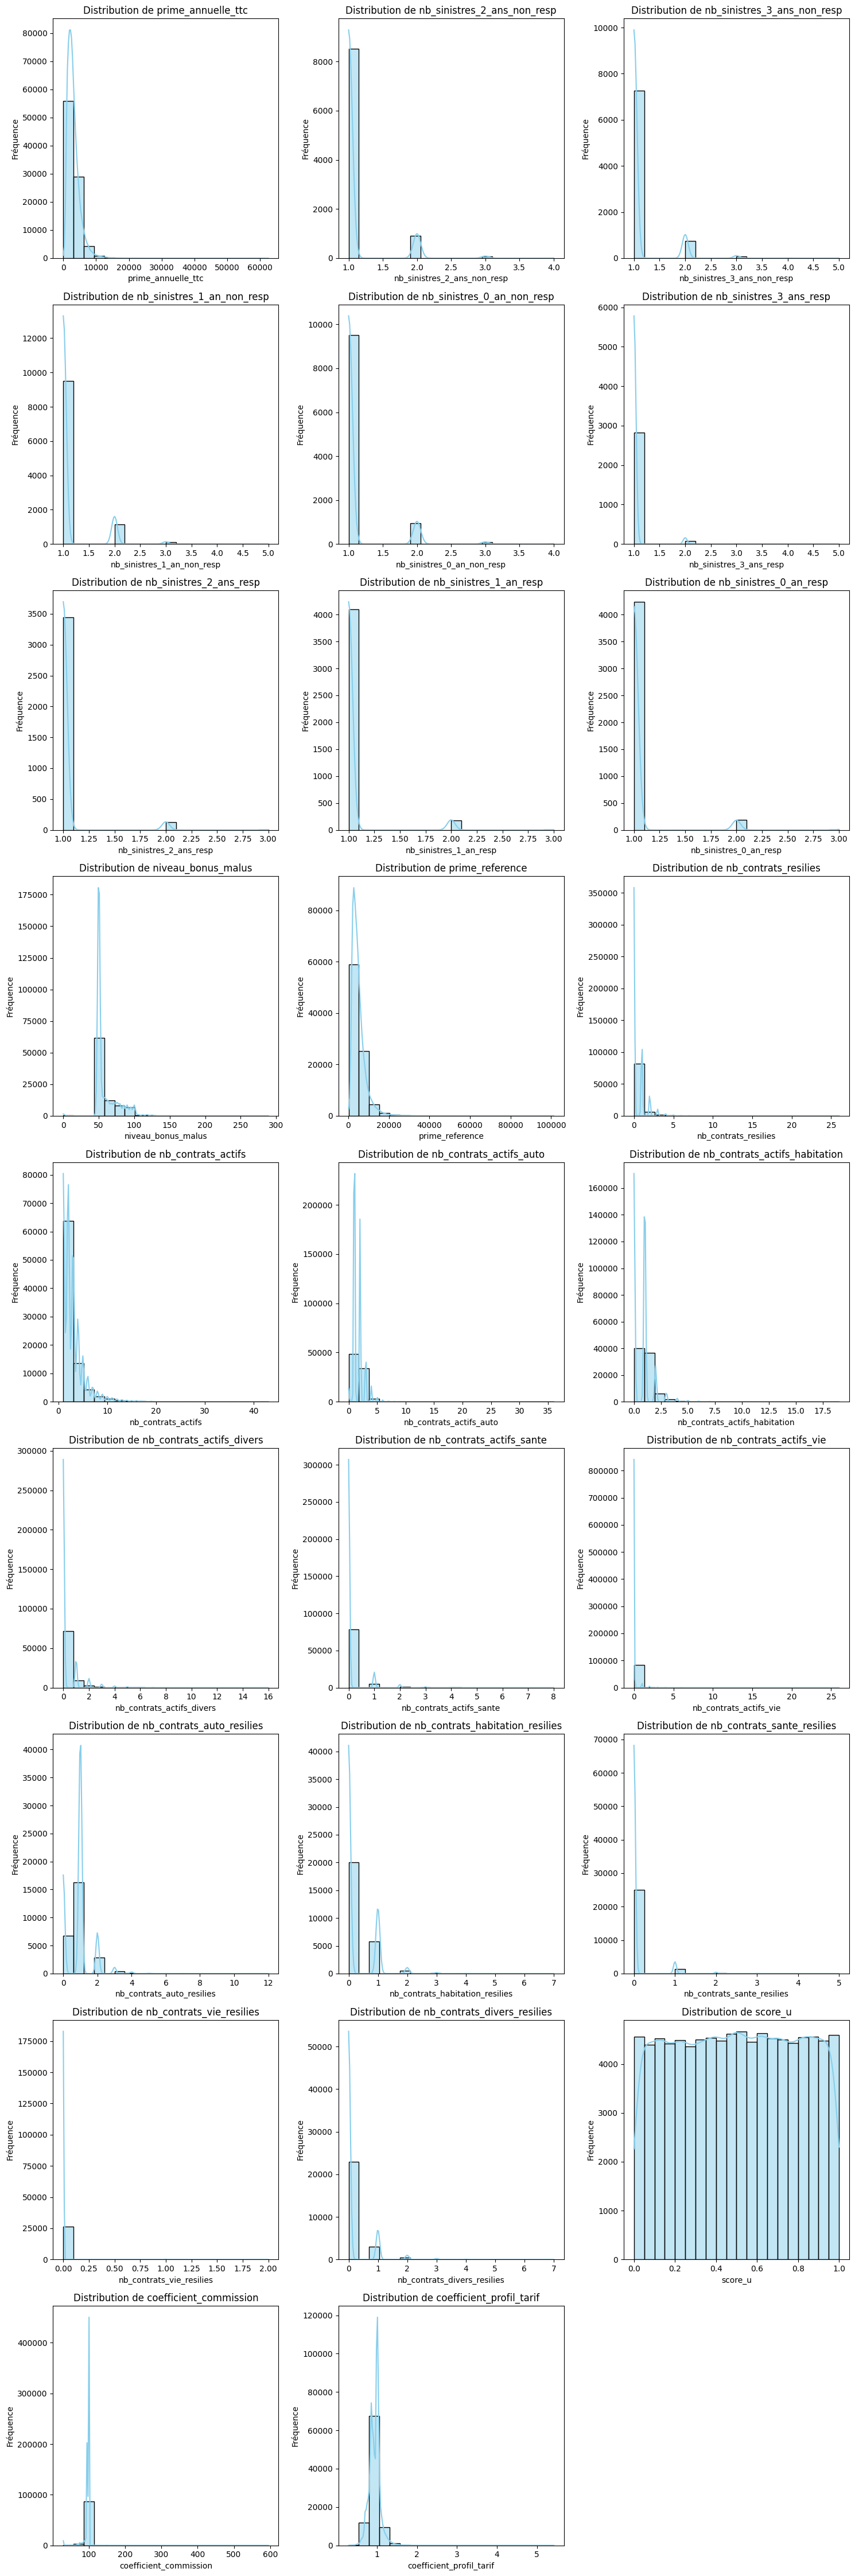

In [ ]:
n_cols = 3
n_rows = (len(var_num) + n_cols - 1) // n_cols  

plt.figure(figsize=(n_cols * 5, n_rows * 5))

for i, col in enumerate(var_num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

⚠️ est ce que mettre les variables de nombre en variables catégorielles ? Pour les modèles basés sur les arbres cela ne risque pas de poser de problèmes mais pour les autres modèle comme logistique je pense. 

#### 2.3.2 Variables de durée

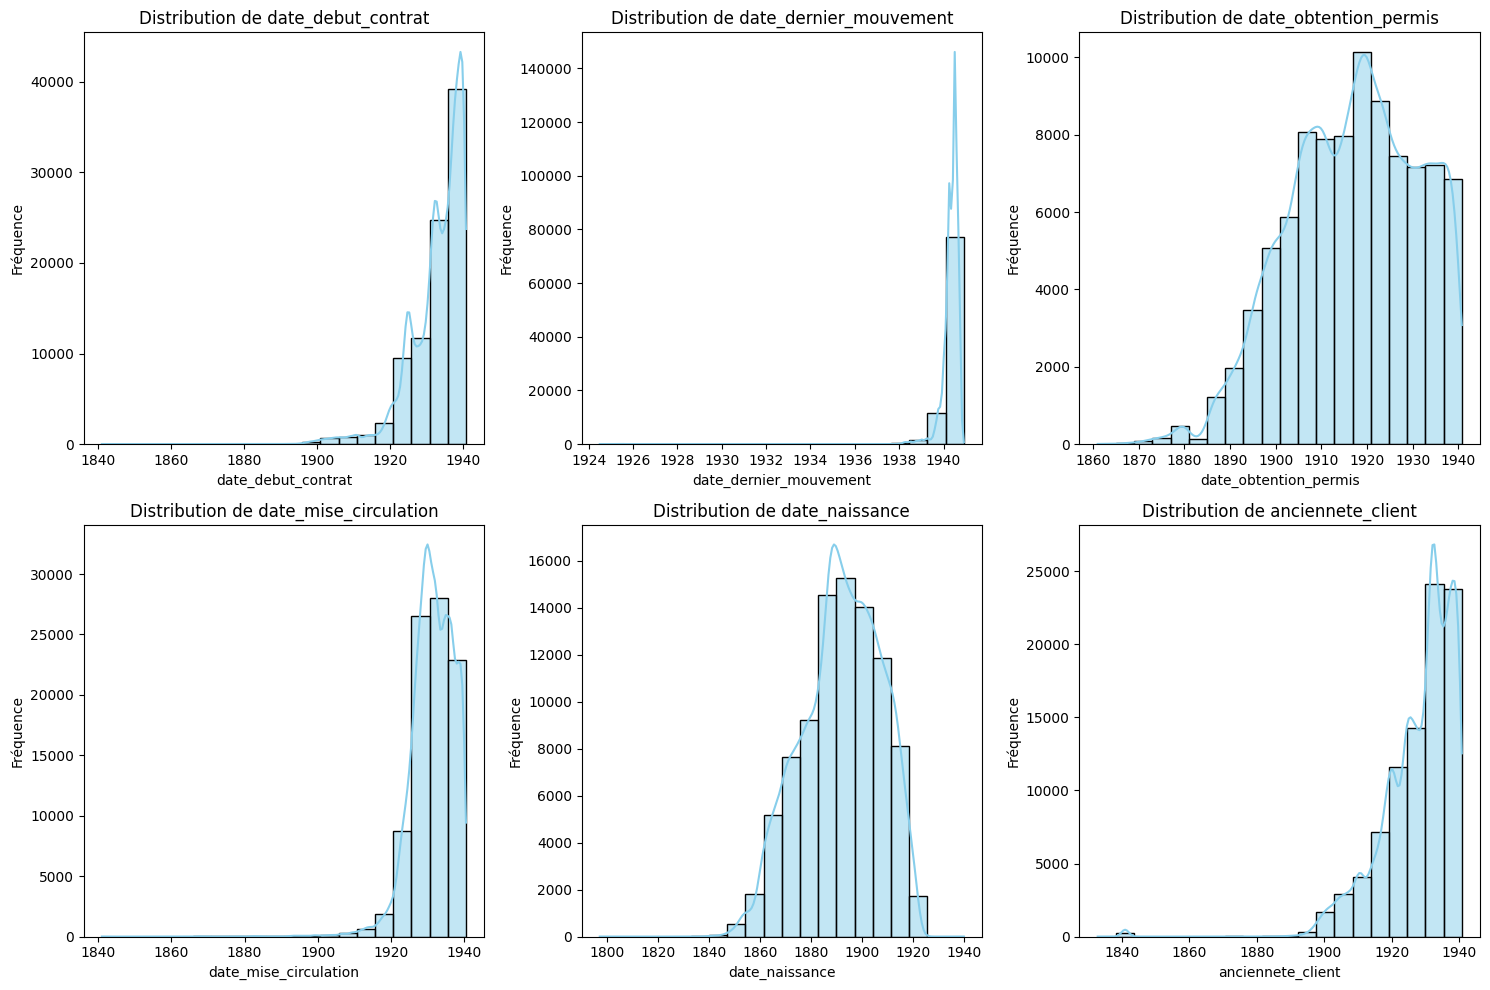

In [ ]:
n_cols = 3
n_rows = (len(var_date) + n_cols - 1) // n_cols  

plt.figure(figsize=(n_cols * 5, n_rows * 5))

for i, col in enumerate(var_date):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

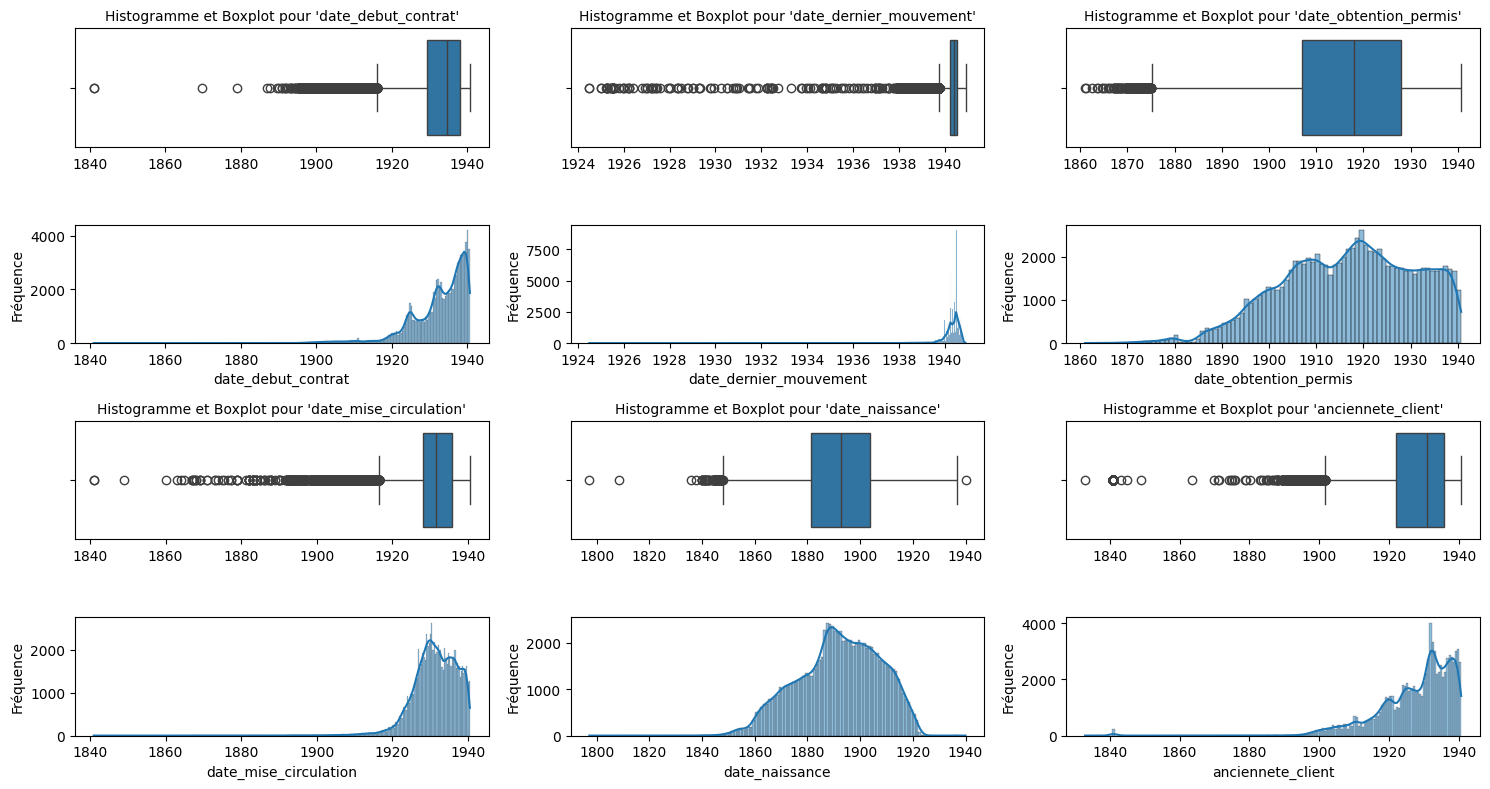

In [ ]:
def hist_box(data, var, ax_box, ax_hist):
    # Boxplot
    sns.boxplot(data=data, x=var, ax=ax_box)
    ax_box.set(xlabel='')
    ax_box.set_title(f"Histogramme et Boxplot pour '{var}'", fontsize=10)

    # Histogramme
    sns.histplot(data=data, x=var, kde=True, ax=ax_hist)
    ax_hist.set(xlabel=var, ylabel='Fréquence')



n_cols = 3
n_rows = (len(var_date) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=False)

if n_rows * 2 == 1:
    axes = [axes]

for idx, var in enumerate(var_date):
    row = (idx // n_cols) * 2  # Ligne du subplot (box + hist)
    col = idx % n_cols

    ax_box = axes[row][col]
    ax_hist = axes[row + 1][col]

    hist_box(df, var, ax_box, ax_hist)

total_slots = n_rows * n_cols
for idx in range(len(var_date), total_slots):
    row = (idx // n_cols) * 2
    col = idx % n_cols
    axes[row][col].axis('off')
    axes[row + 1][col].axis('off')

plt.tight_layout()
plt.show()


⚠️ Dis moi les graph que tu pref pour les variables continues.

#### 2.3.3 Variables catégorielles

In [ ]:
# Retirer les variables catégorielles qui ne sont pas pertinentes pour l'analyse :
var_cat_graph = [col for col in var_cat if df[col].nunique() < 50]
df[var_cat_graph]

,code_formule,code_produit_gestion,numero_tarif,rang_valeur_vehicule,code_marche,sexe,situation_familiale,region,client_actif,contrat,etat,motif_resiliation
0,R,4190A,BL050,5.0,P,F,M,RA,OUI,ACTIF,CO,NaN
1,C,4190A,BL064,10.0,P,M,M,RA,OUI,ACTIF,CO,NaN
2,C,4190A,BL100,4.0,P,M,M,RA,OUI,ACTIF,CO,NaN
3,C,4190A,BL100,10.0,P,M,C,RA,OUI,ACTIF,CO,NaN
4,S,4190A,BL064,15.0,P,M,M,RA,OUI,ACTIF,CO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
90242,S,4190A,BL050,8.0,P,F,A,MM,OUI,ACTIF,CO,NaN
90243,C,4190A,BL064,8.0,P,M,C,MM,OUI,ACTIF,CO,NaN
90244,C,4190A,BL064,6.0,P,M,M,NE,OUI,ACTIF,CO,NaN
90245,C,4190A,BL090,3.0,P,F,C,NE,OUI,ACTIF,CO,NaN


/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_6769/956134913.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='Set2')
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_6769/956134913.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='Set2')
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_6769/956134913.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='Set2')
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_6769/956

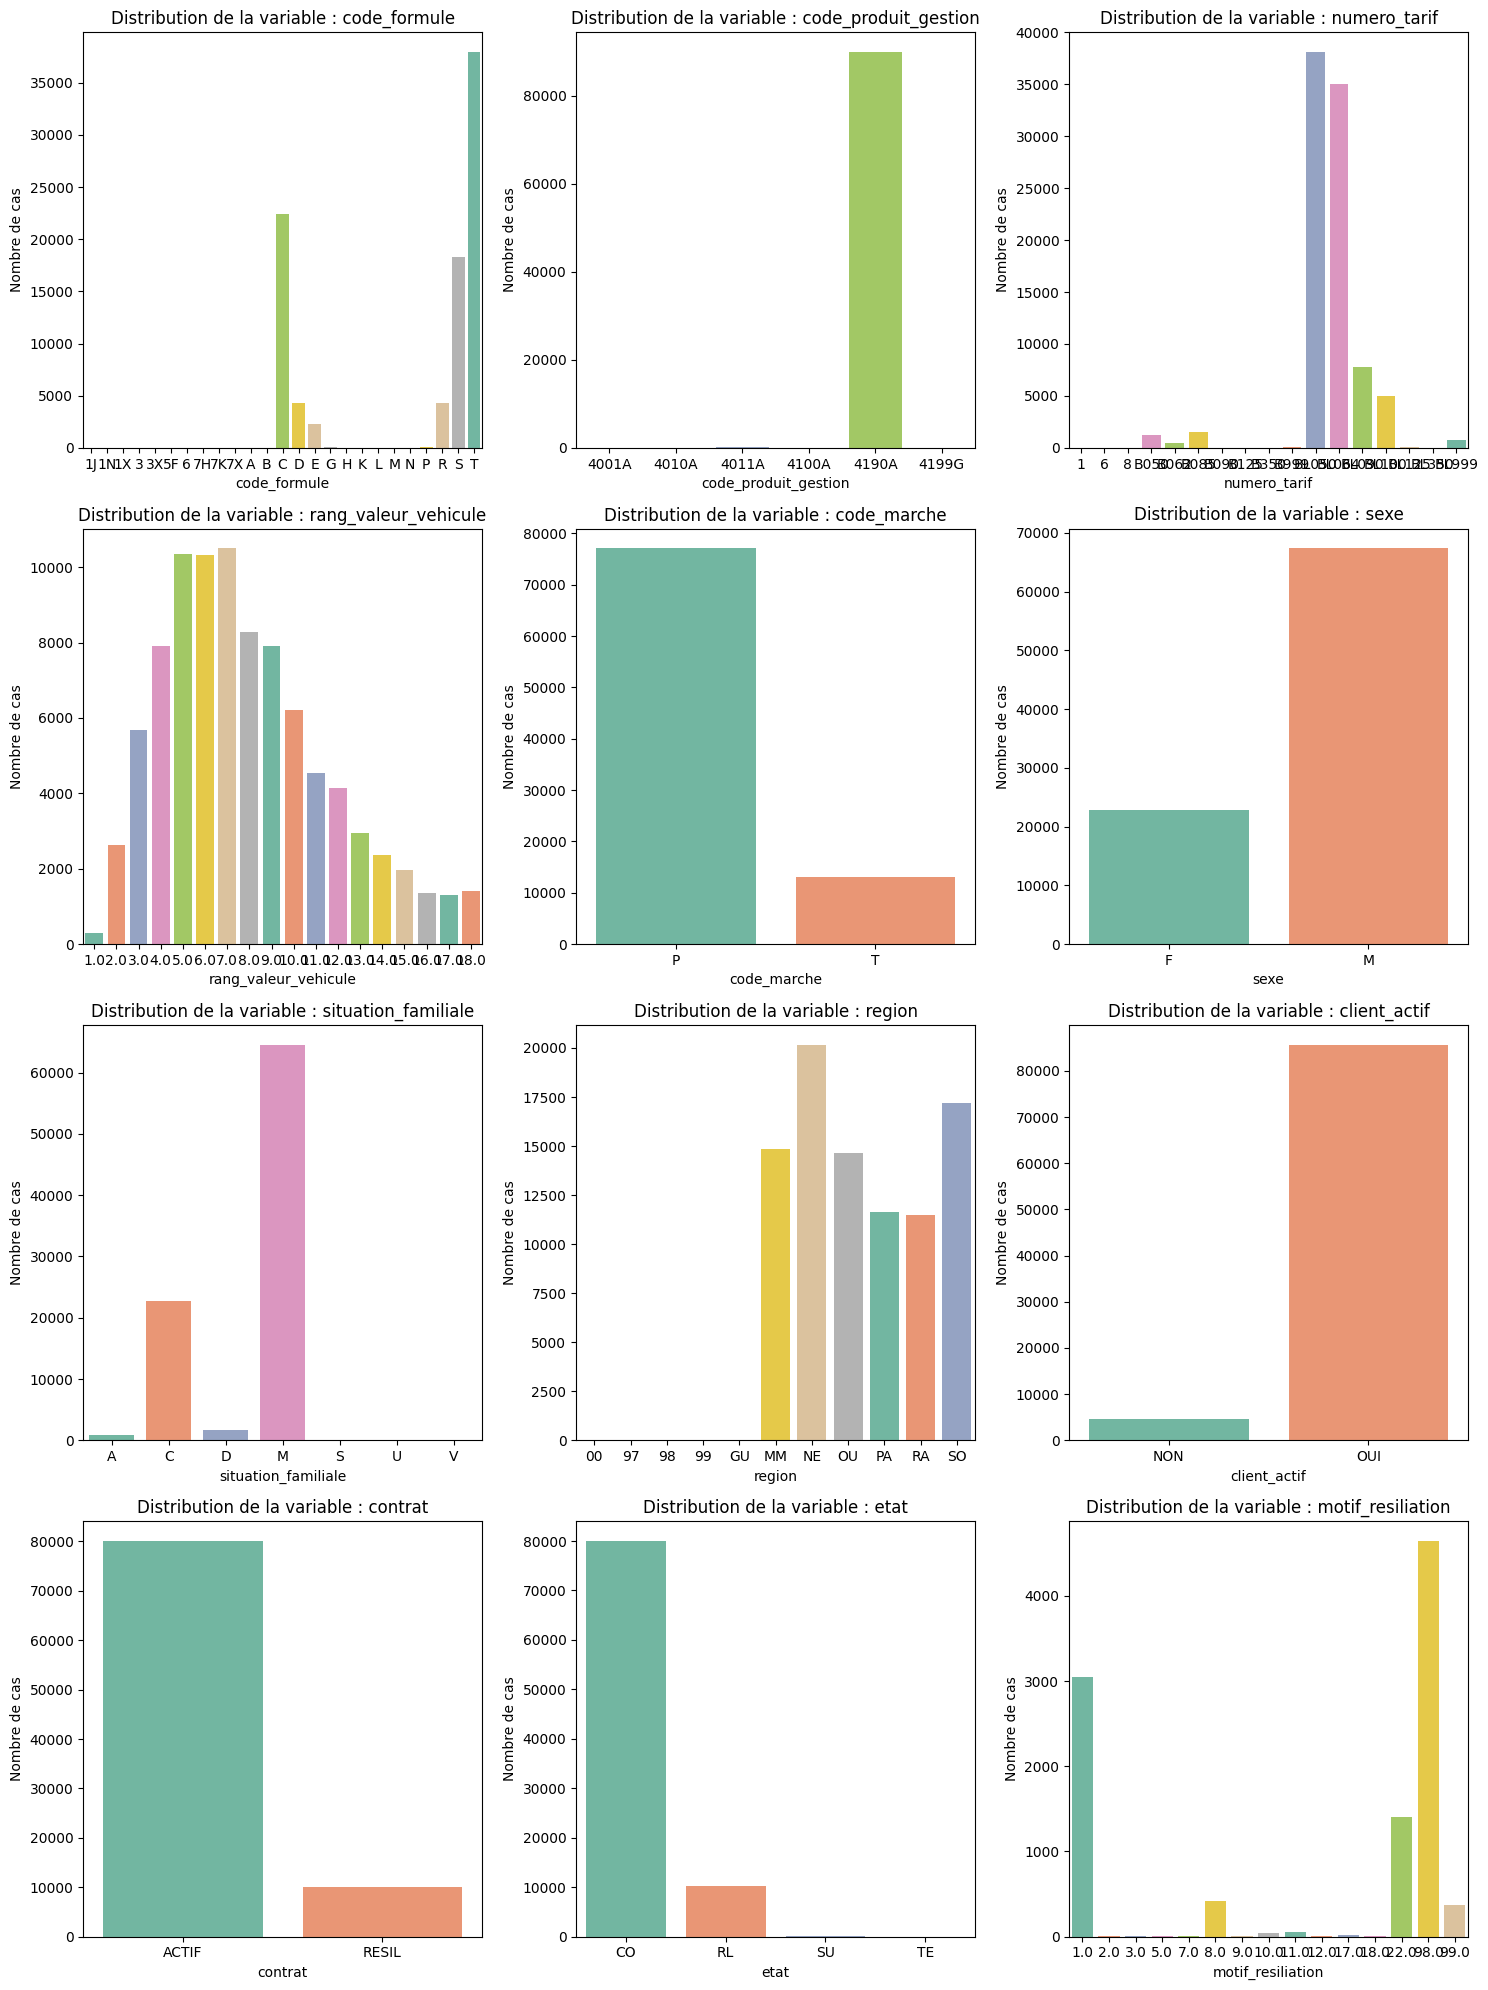

In [ ]:
n_cols = 3
n_rows = (len(var_cat_graph) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires

plt.figure(figsize=(n_cols * 5, n_rows * 5))  
for i, col in enumerate(var_cat_graph):
    plt.subplot(n_rows, n_cols, i + 1)  
    sns.countplot(x=col, data=df, palette='Set2')  
    plt.title(f'Distribution de la variable : {col}')
    plt.xlabel(col)
    plt.ylabel('Nombre de cas')

plt.tight_layout() 
plt.show()


### 2.5 Representation graphique de chaque variable en fonction de la variable cible 

#### 2.5.1 Représentations graphiques des catégorielles par rapport à la cible

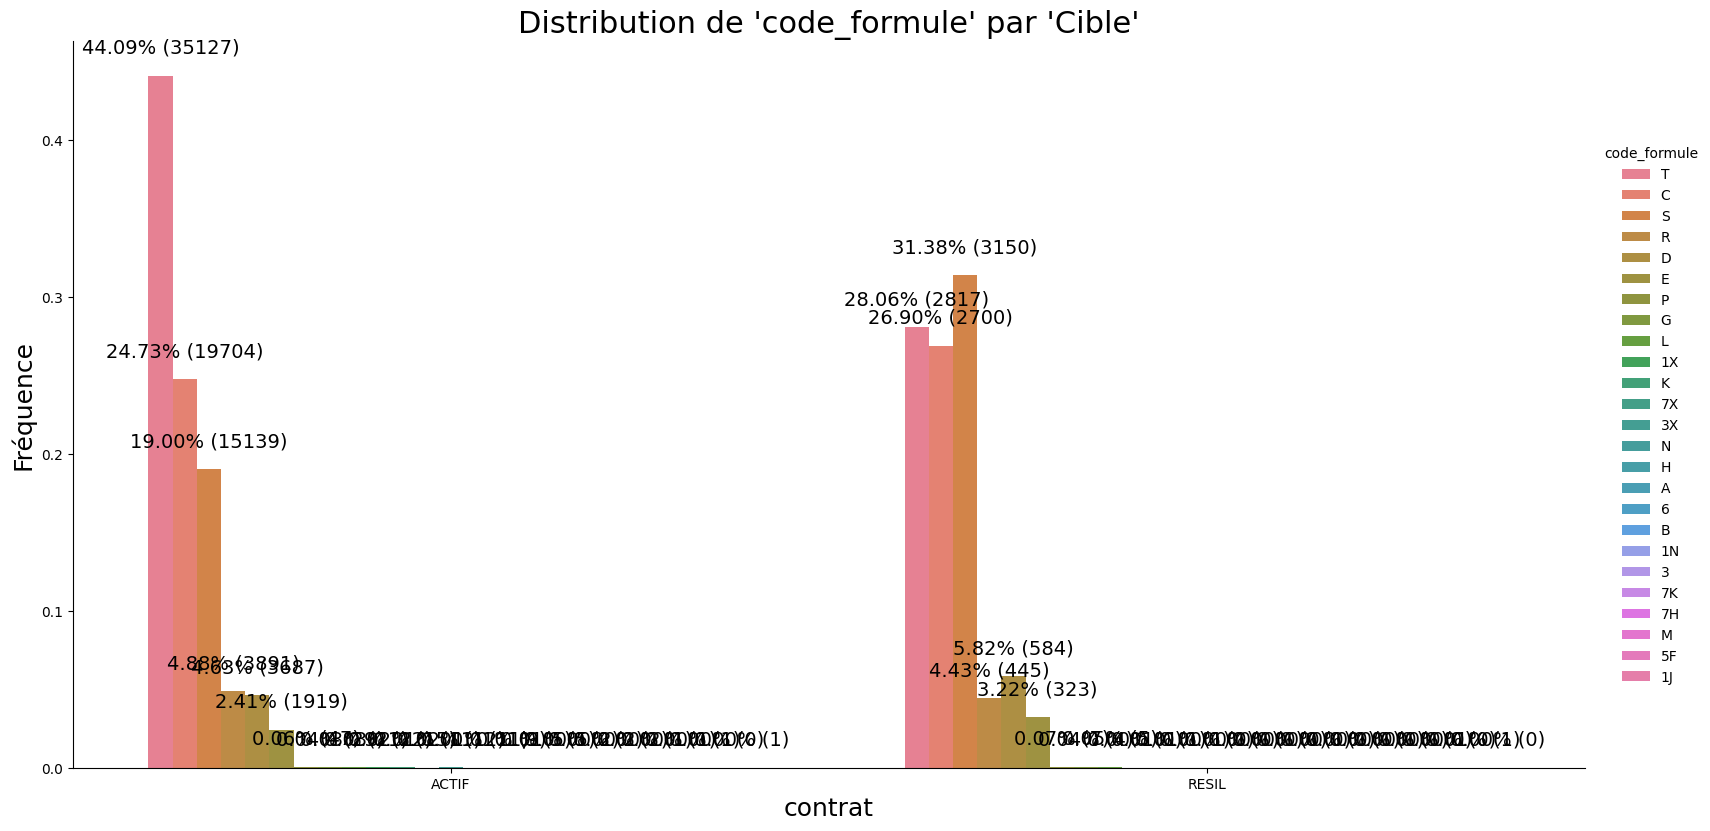

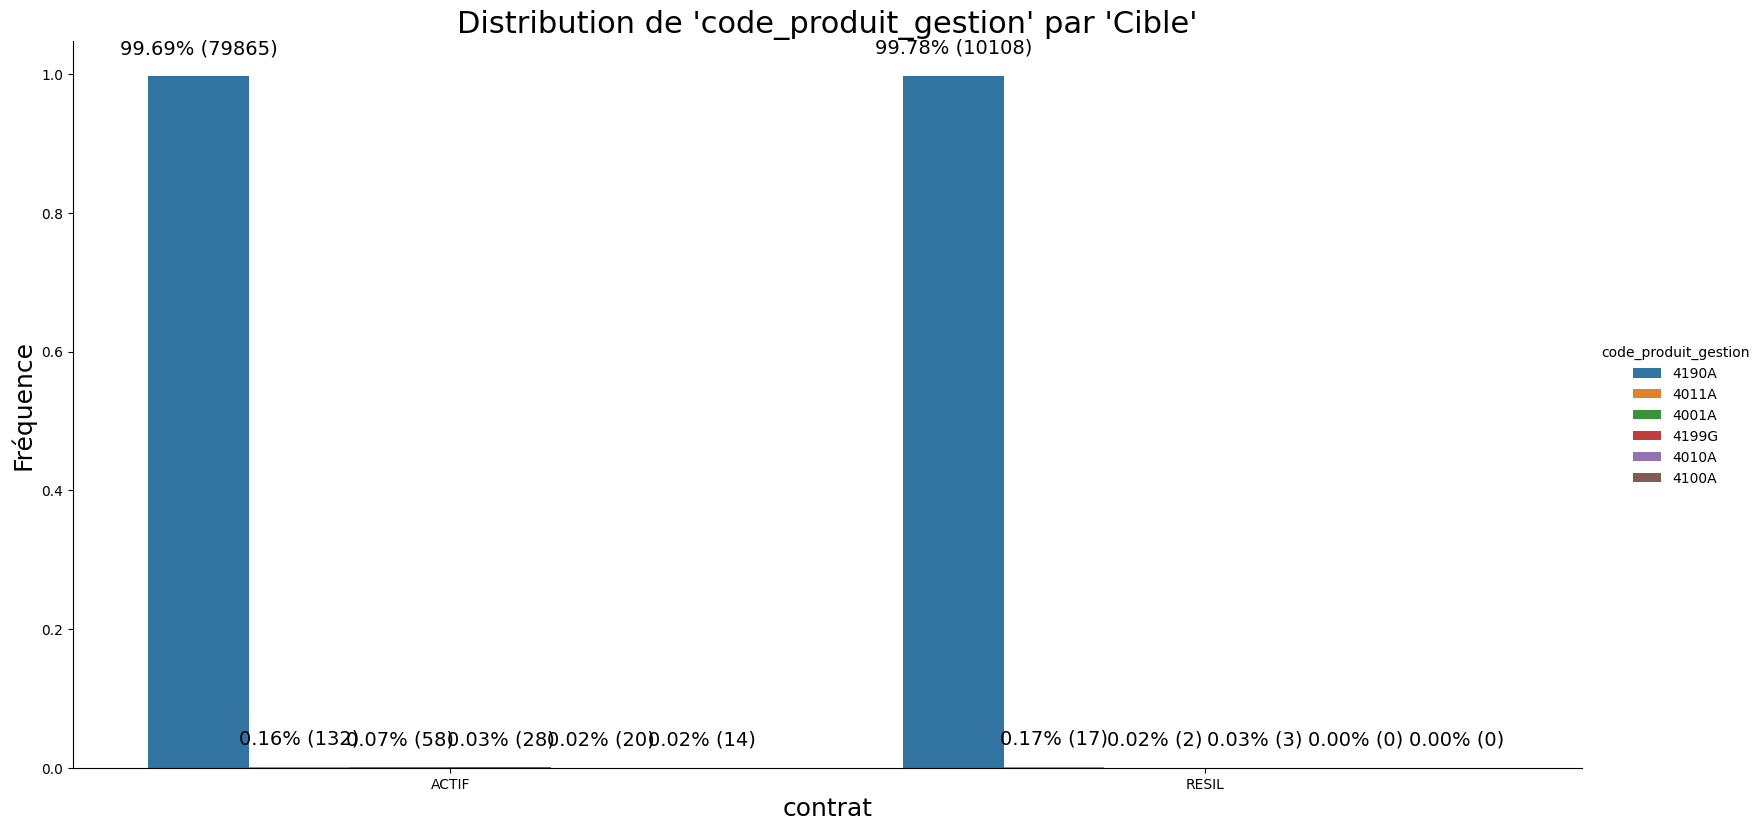

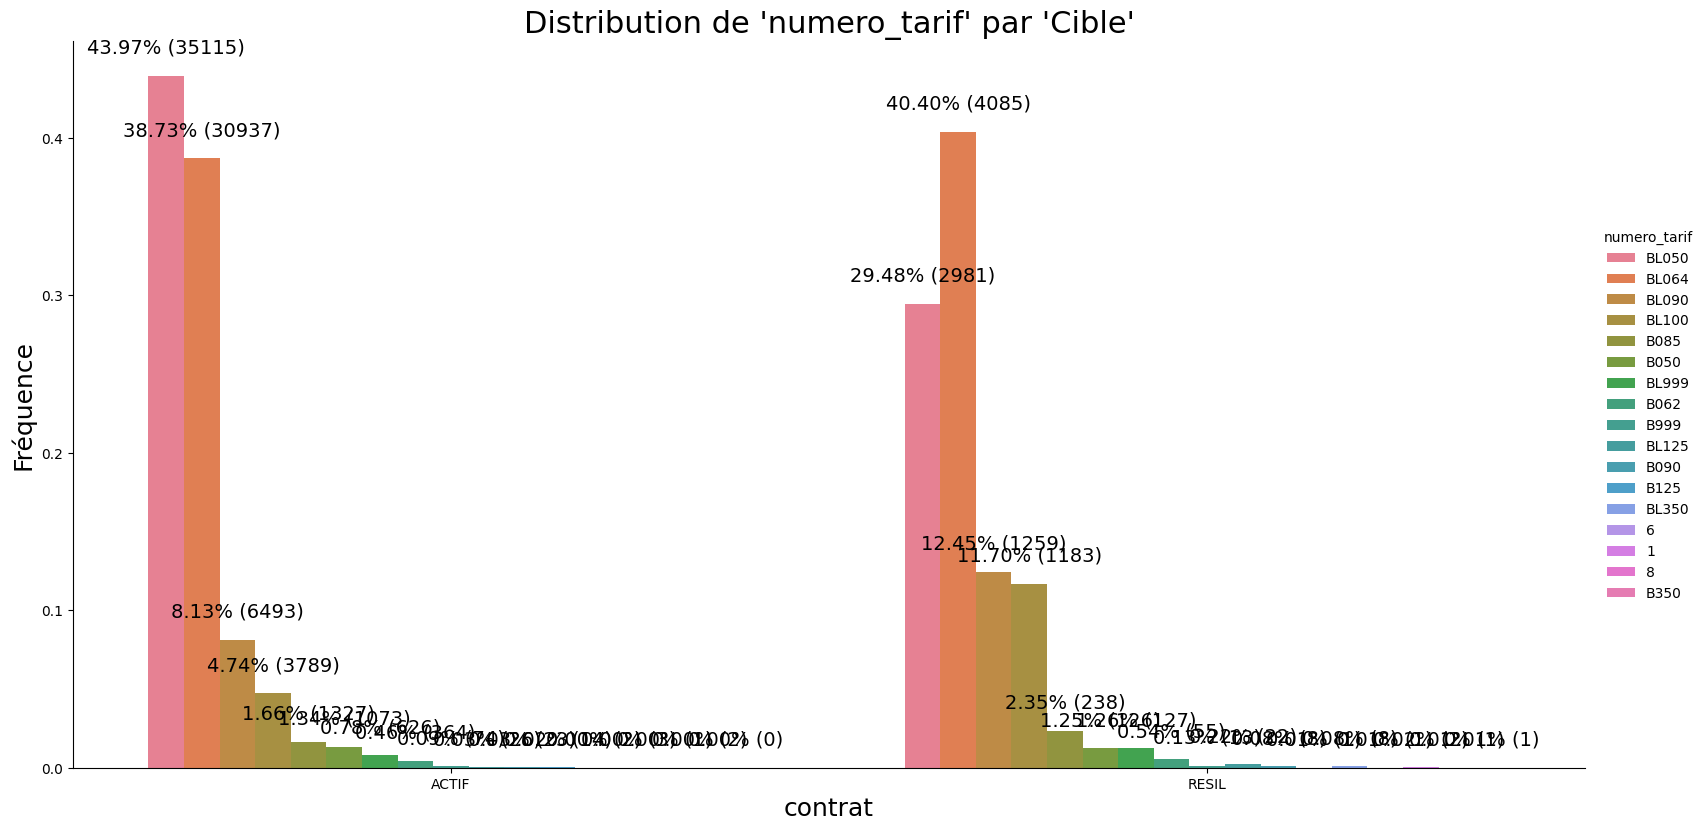

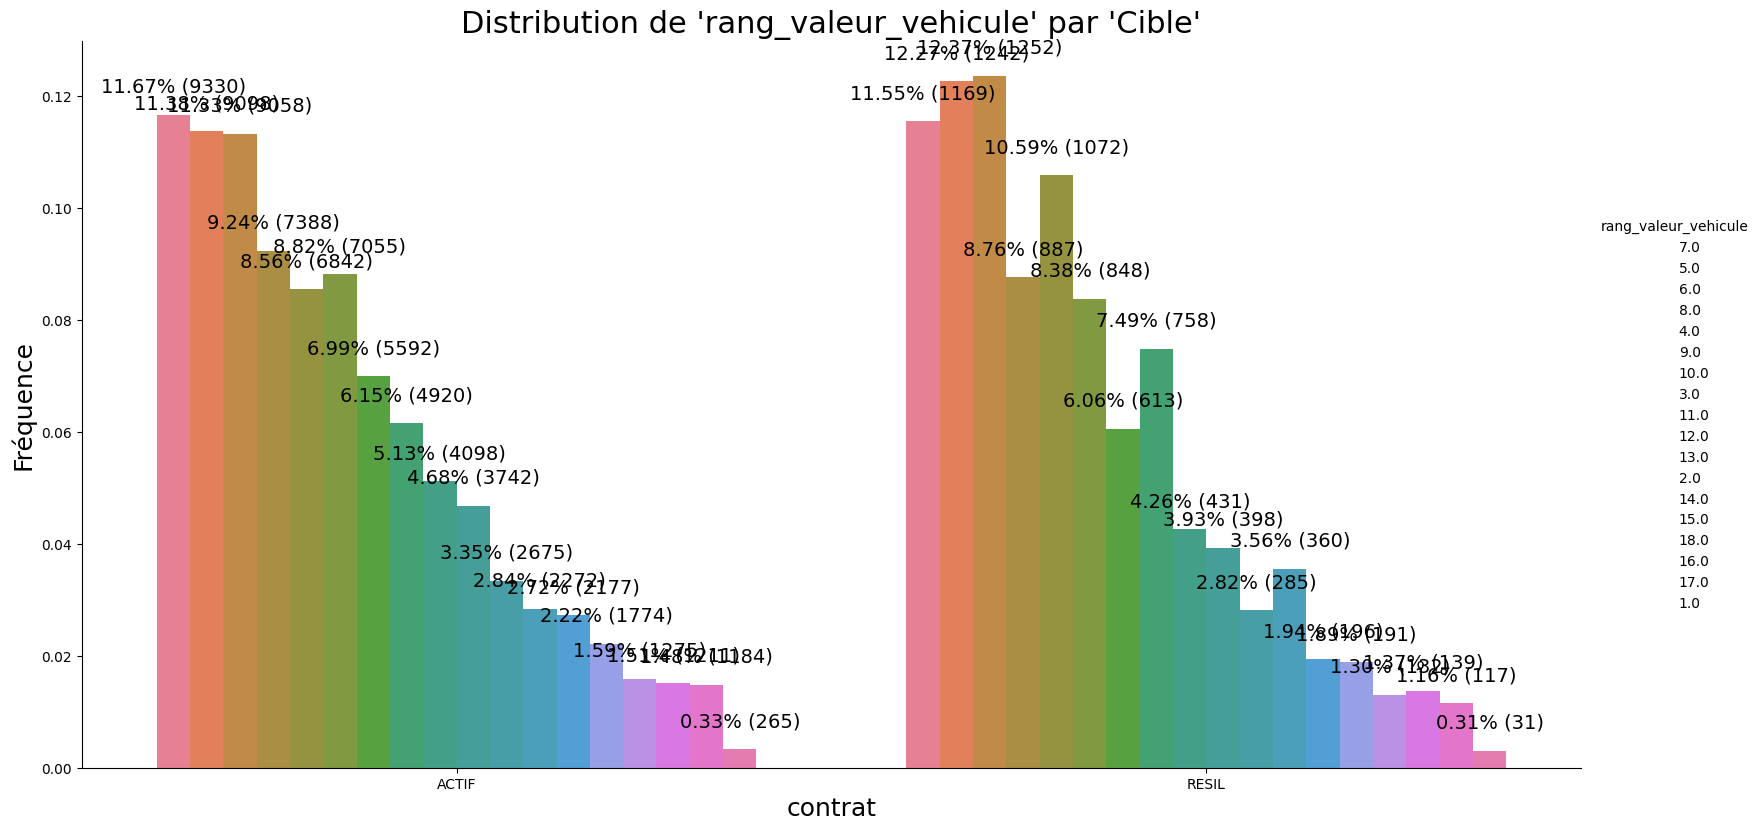

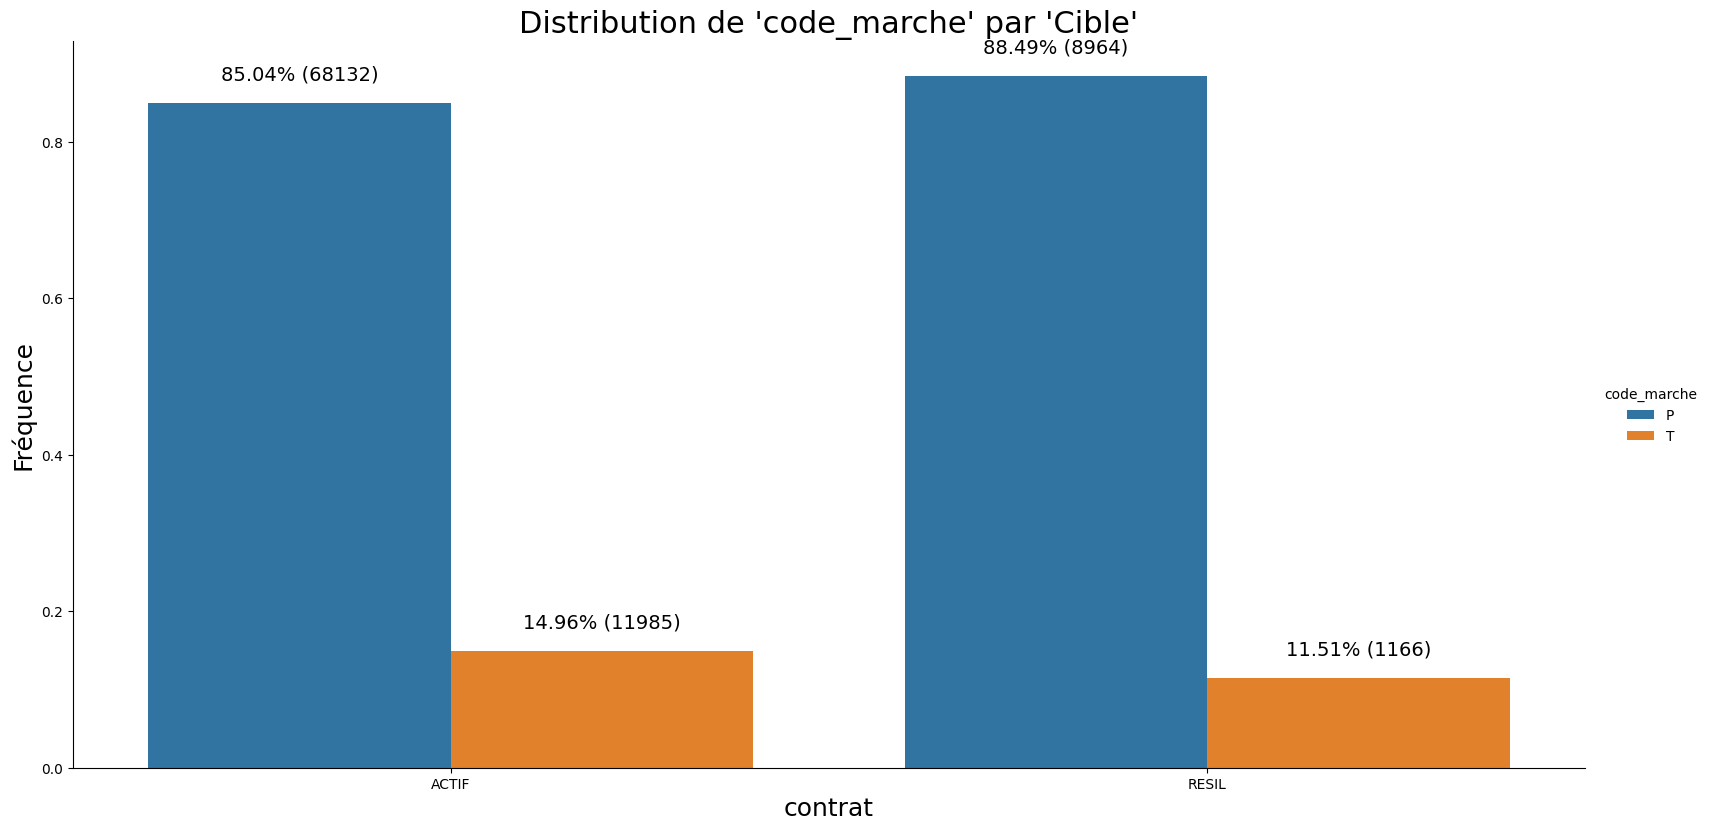

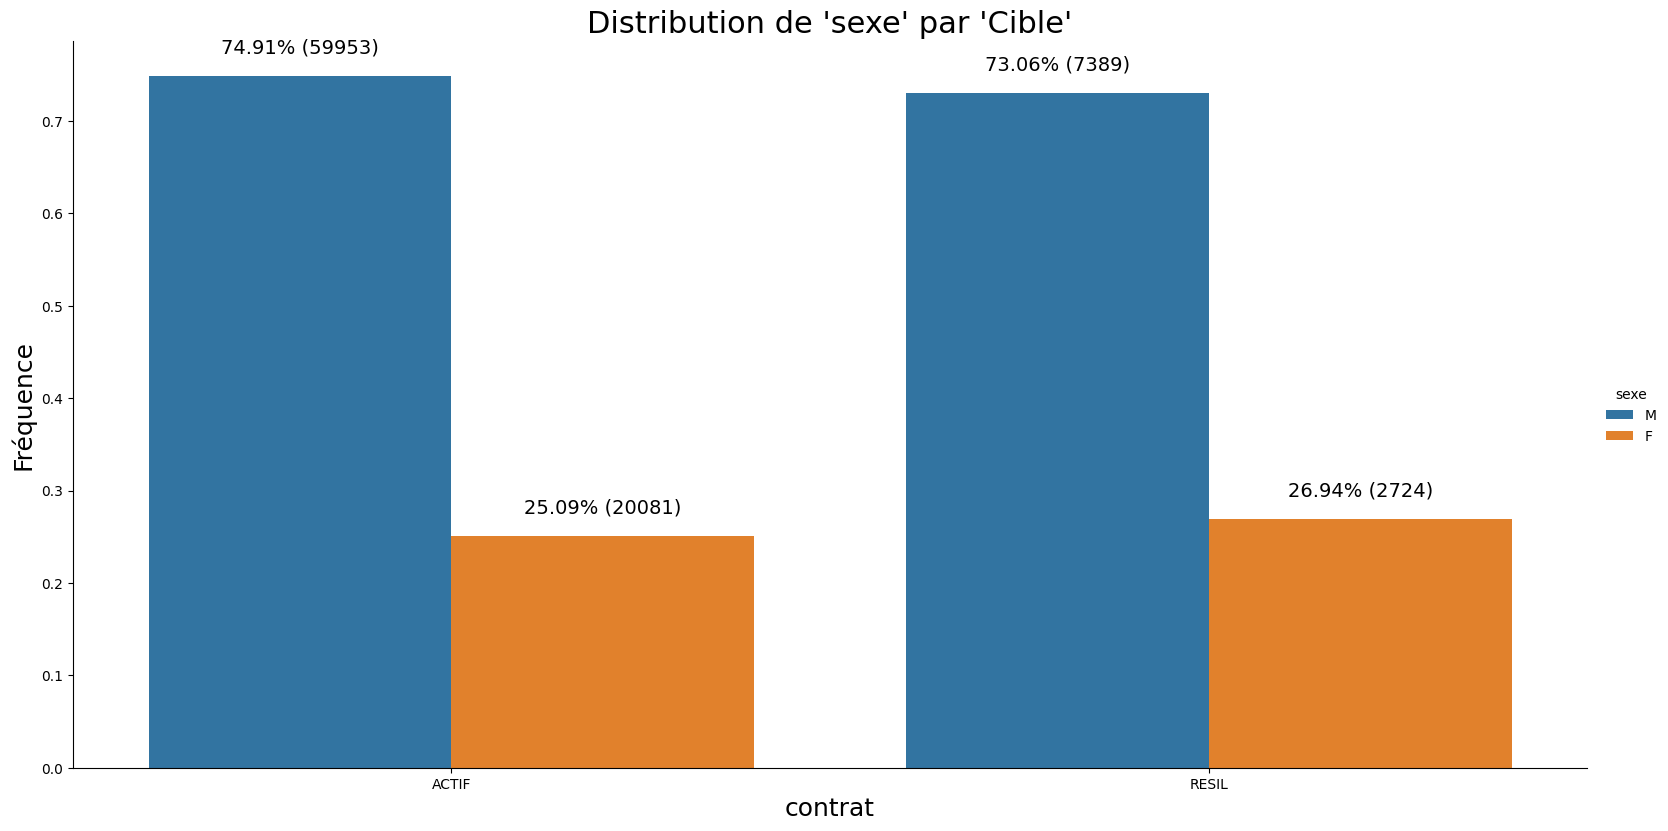

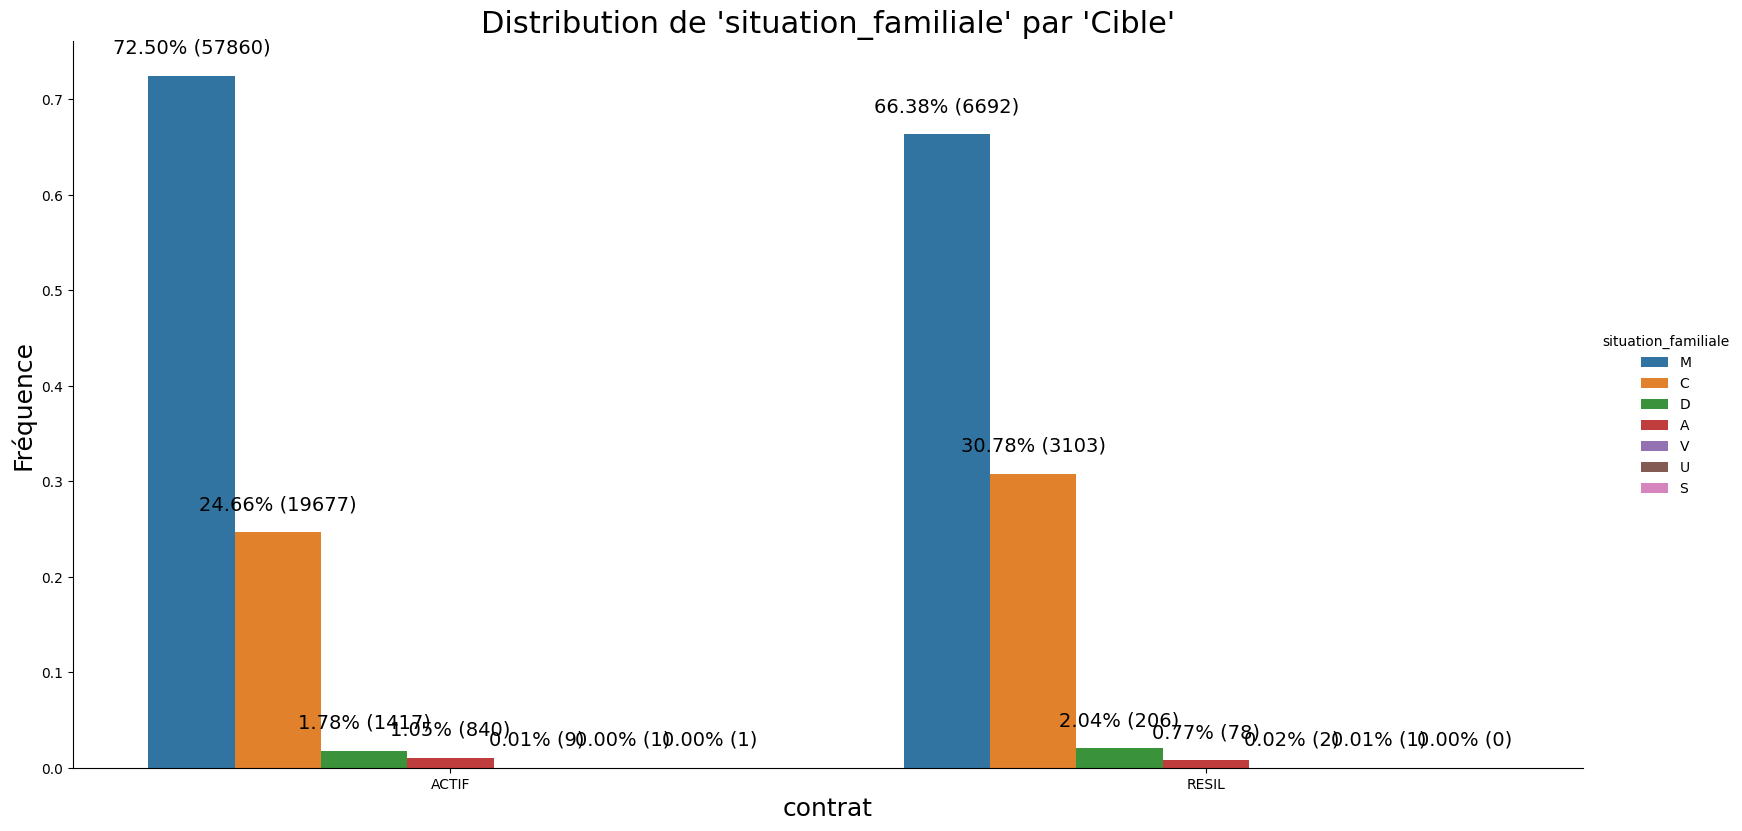

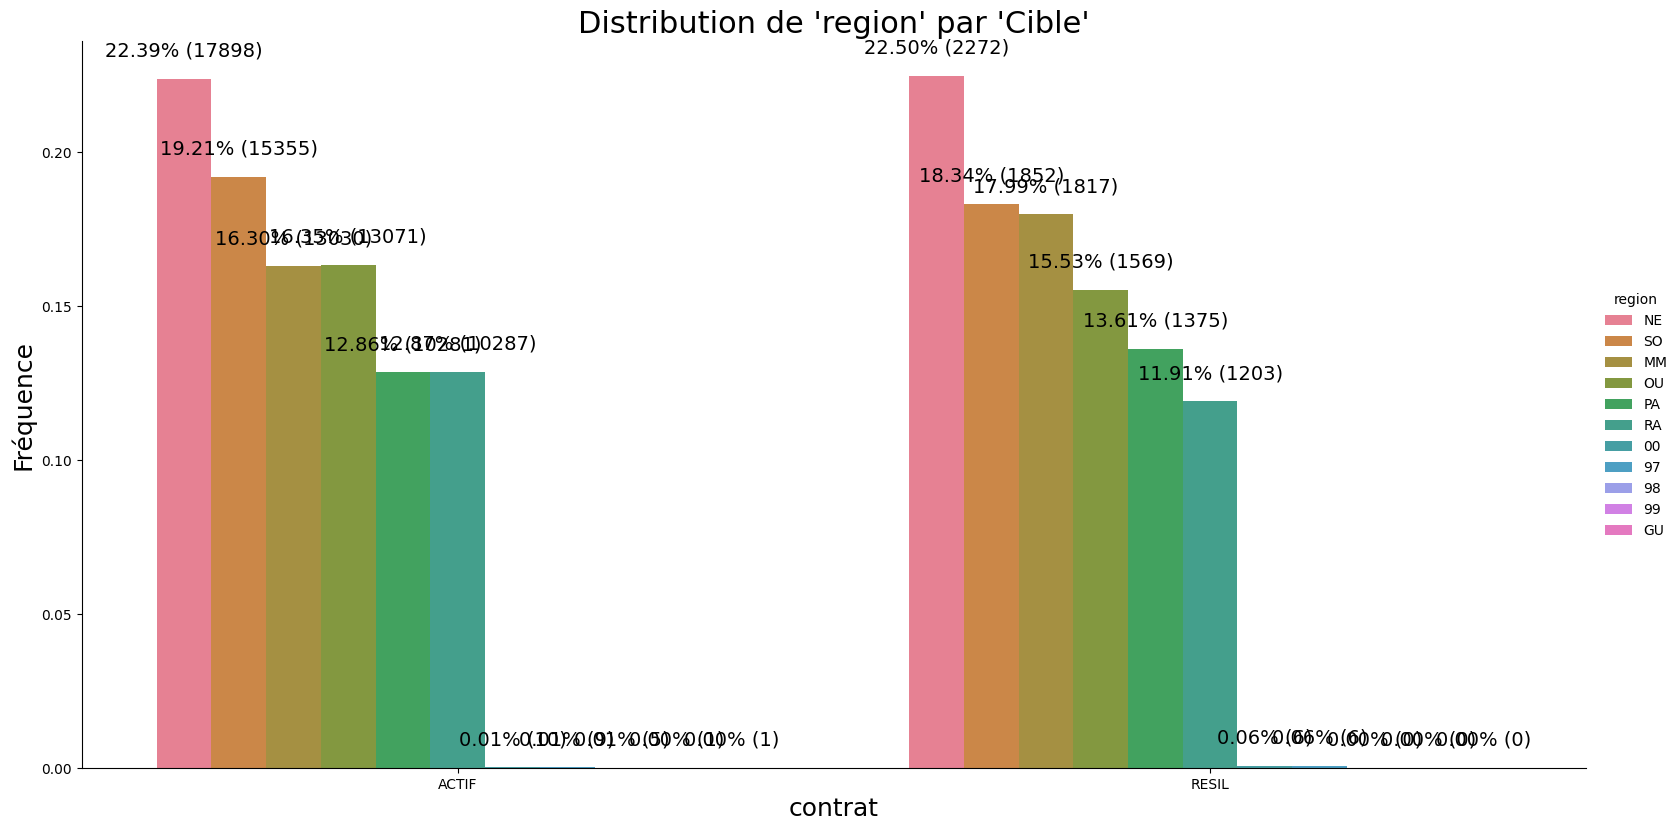

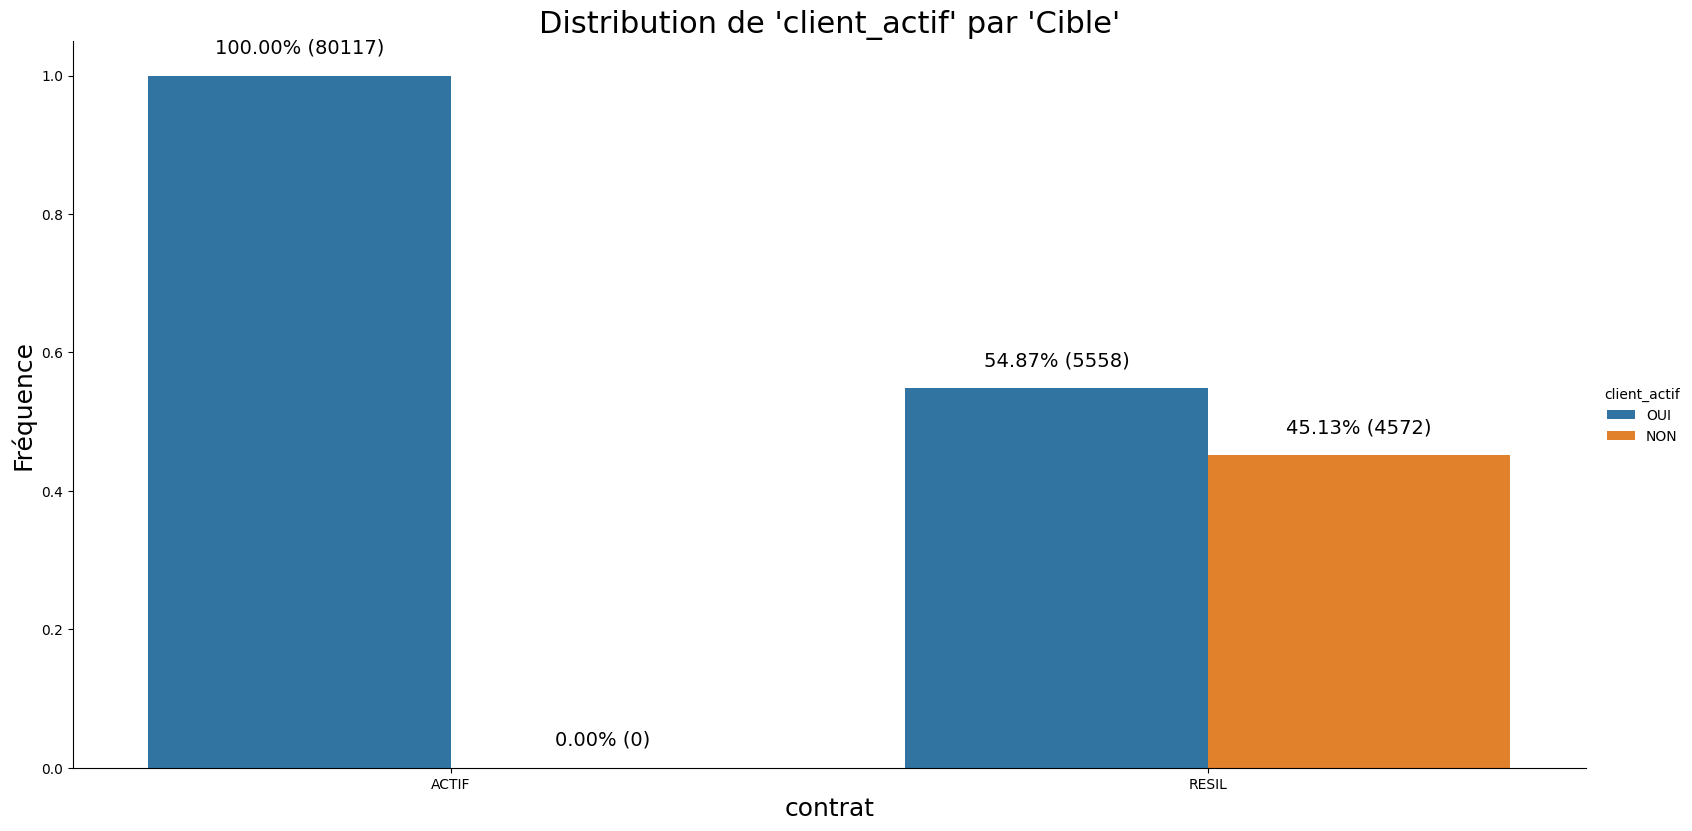

ValueError: The column label 'contrat' is not unique.

In [ ]:
for col in var_cat_graph:
    distrib_for_cat_by_target(col,df,"contrat")